In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from dataclasses import dataclass
from typing import List, Tuple, Dict
import heapq
import scipy.stats

/Users/tolkienbagchi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("data1_v2.csv")
aggregated_df = df.groupby(['geoid', 'year'])['emissions_98'].sum().reset_index() # aggregate data geoid, year, emissions_98

In [52]:
min_year = aggregated_df['year'].min()
max_year = aggregated_df['year'].max()
print(min_year)
print(max_year)


1990
2060


In [3]:
# Fill in missing values
min_year = int(aggregated_df['year'].min()) # Year originally stored as float
max_year = int(aggregated_df['year'].max())
all_years = range(min_year, max_year + 1)

# Create new DataFrame with all geoid-year combinations
all_geoids = aggregated_df['geoid'].unique()
complete_index = pd.MultiIndex.from_product([all_geoids, all_years], names=['geoid', 'year'])
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Merge with existing data
merged_df = complete_df.merge(aggregated_df, on=['geoid', 'year'], how='left')

# Sort by geoid and year for proper interpolation
merged_df = merged_df.sort_values(['geoid', 'year'])

# Fill in missing values within each geoid group using pandas linear interpolation
filled_df = merged_df.groupby('geoid')['emissions_98'].apply(
    lambda group: group.interpolate(method='linear')
).reset_index()

# Merge back to get the complete DataFrame
result_df = merged_df[['geoid', 'year']].merge(
    filled_df[['geoid', 'emissions_98']],
    left_index=True,
    right_index=True
)
result_df = result_df.drop('geoid_y', axis = 1)
result_df = result_df.rename(columns={'geoid_x': 'geoid'})

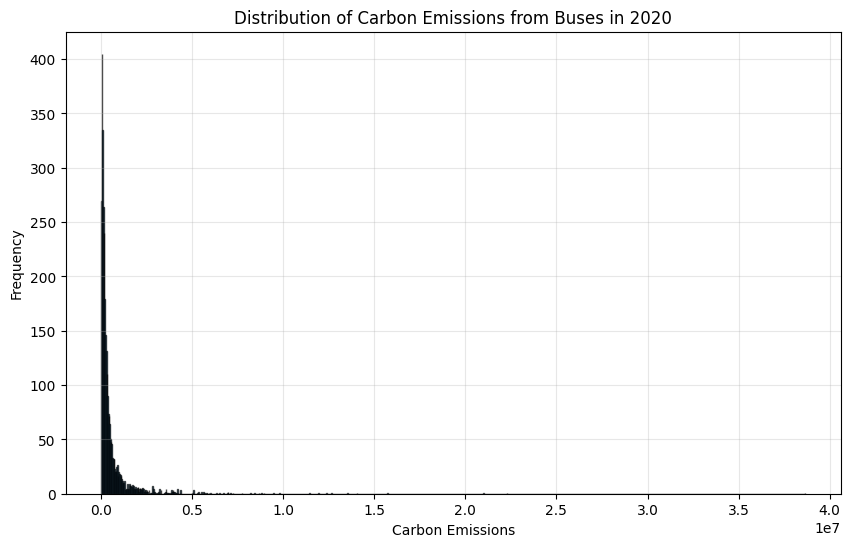

In [5]:
# Filter for 2020 data
emissions_2020 = result_df[result_df['year'] == 2020]['emissions_98']

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(emissions_2020, bins=1000, edgecolor='black', alpha=0.7)
plt.xlabel('Carbon Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of Carbon Emissions from Buses in 2020')
plt.grid(True, alpha=0.3)
plt.show()

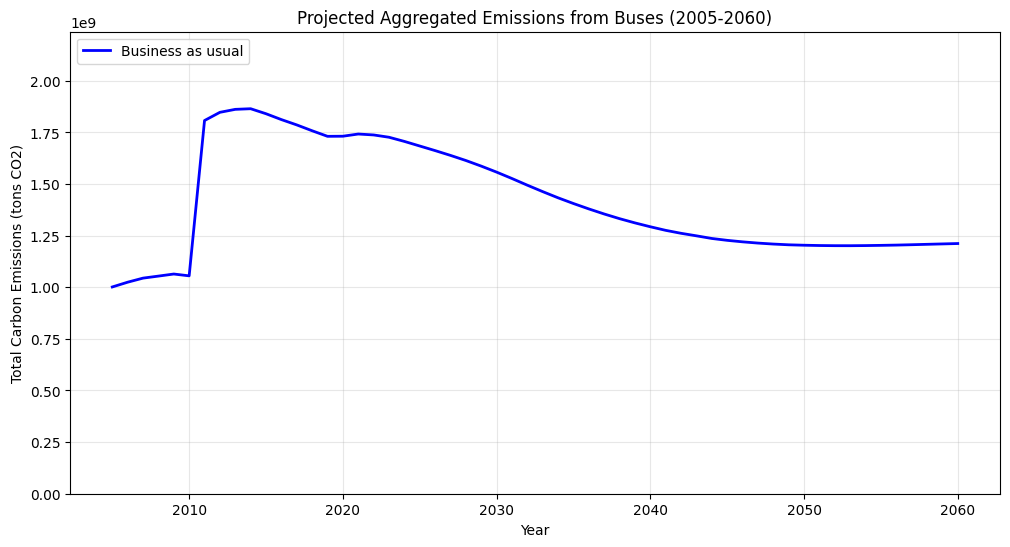

In [6]:
def plot_data(a, b, df = result_df):

  yearly_totals = df.groupby('year')['emissions_98'].sum().reset_index()

  # Filter for 2020-2060
  plot_data = yearly_totals[(yearly_totals['year'] >= a) & (yearly_totals['year'] <= b)]

# Create the plot
  plt.figure(figsize=(12, 6))
  plt.plot(plot_data['year'], plot_data['emissions_98'], 'b-', linewidth=2)
  plt.xlabel('Year')
  plt.ylim(0, 1.2 * plot_data['emissions_98'].max())
  plt.ylabel('Total Carbon Emissions (tons CO2)')
  plt.title('Projected Aggregated Emissions from Buses (' + str(a) + '-' + str(b) + ')')
  plt.grid(True, alpha=0.3)
  plt.legend(['Business as usual'], loc='upper left')
  plt.show()

plot_data(2005, 2060)

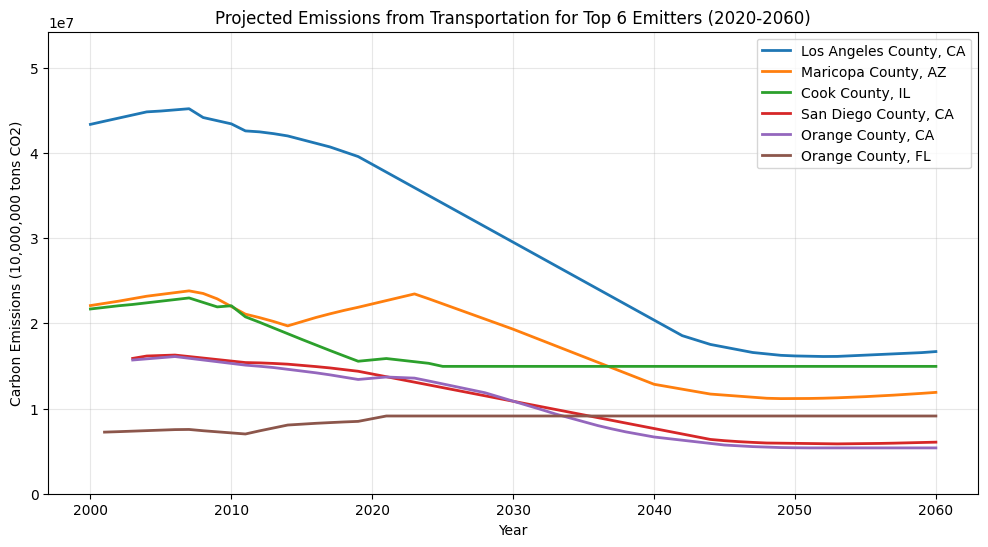

In [8]:
# List of geoids
selected_geoids = [6037, 4013, 17031, 6073, 6059] #list of raw geoids (note that df drops the zeroes so eg when searching 6037 should be 06037)
counties = [[6037, 'Los Angeles County, CA'], [4013, 'Maricopa County, AZ'], [17031, 'Cook County, IL'], [6073, 'San Diego County, CA'], [6059, 'Orange County, CA'], [12095, 'Orange County, FL']] # searched corresponding counties by hand

selected_geoids = [geoid for geoid, _ in counties]
# Filter for selected geoids and years 2020-2060

selected_data = result_df[
    (result_df['geoid'].isin(selected_geoids)) &
    (result_df['year'] >= 2000)
]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each geoid separately
for geoid, name in counties:
    geoid_data = selected_data[selected_data['geoid'] == geoid]
    plt.plot(geoid_data['year'], geoid_data['emissions_98'],
             linewidth=2, label=f'{name}')

plt.xlabel('Year')
plt.ylabel('Carbon Emissions (10,000,000 tons CO2)')
plt.ylim(0, 1.2 * selected_data['emissions_98'].max())
plt.title('Projected Emissions from Transportation for Top 6 Emitters (2020-2060)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
def analyze_county_performance(original_df, debt_df, county_geoid, year_range=None):
    """
    Analyze a specific county's performance vs targets
    
    Args:
        original_df: Original emissions dataframe
        debt_df: Carbon debt dataframe  
        county_geoid: GEOID of county to analyze
        year_range: Tuple of (start_year, end_year), defaults to (2020, 2050)
    
    Returns:
        DataFrame with county analysis
    """
    
    if year_range is None:
        year_range = (2020, 2050)
    
    # Filter data for specific county and year range
    county_orig = original_df[
        (original_df['geoid'] == county_geoid) & 
        (original_df['year'] >= year_range[0]) & 
        (original_df['year'] <= year_range[1])
    ].copy()
    
    county_debt = debt_df[
        (debt_df['geoid'] == county_geoid) & 
        (debt_df['year'] >= year_range[0]) & 
        (debt_df['year'] <= year_range[1])
    ].copy()
    
    # Merge the data
    analysis = county_orig.merge(
        county_debt[['year', 'emissions_98']].rename(columns={'emissions_98': 'carbon_debt'}),
        on='year', how='left'
    )
    
    # Calculate target emissions
    analysis['target_emissions'] = analysis['emissions_98'] - analysis['carbon_debt']
    
    # Calculate cumulative debt
    analysis['cumulative_debt'] = analysis['carbon_debt'].cumsum()
    
    return analysis

def validate_baseline_calculation(df, sample_geoids=None):
    """
    Validate the baseline calculation for a sample of counties
    
    Args:
        df: Original dataframe
        sample_geoids: List of GEOIDs to check, if None will sample randomly
    
    Returns:
        DataFrame showing baseline validation results
    """
    
    if sample_geoids is None:
        # Sample 10 random counties
        unique_geoids = df['geoid'].unique()
        sample_geoids = np.random.choice(unique_geoids, min(10, len(unique_geoids)), replace=False)
    
    validation_results = []
    baseline_2005 = df[df['year'] == 2005].set_index('geoid')['emissions_98']
    
    for geoid in sample_geoids:
        county_data = df[df['geoid'] == geoid].sort_values('year')
        
        # Check what baseline would be used
        uses_2005 = False
        actual_baseline = 0
        baseline_year = None
        
        # Check 2005 first
        if geoid in baseline_2005.index:
            baseline_2005_value = baseline_2005[geoid]
            if pd.notna(baseline_2005_value) and baseline_2005_value > 0:
                uses_2005 = True
                actual_baseline = baseline_2005_value
                baseline_year = 2005
        
        # If not 2005, get earliest
        if not uses_2005:
            for _, row in county_data.iterrows():
                value = row['emissions_98']
                if pd.notna(value) and value > 0:
                    actual_baseline = value
                    baseline_year = row['year']
                    break
        
        # Get 2005 value for comparison (even if invalid)
        value_2005 = baseline_2005.get(geoid, np.nan) if geoid in baseline_2005.index else np.nan
        
        validation_results.append({
            'geoid': geoid,
            'baseline_used': actual_baseline,
            'baseline_year': baseline_year,
            'uses_2005': uses_2005,
            '2005_value': value_2005,
            'earliest_year': county_data['year'].min(),
            'earliest_value': county_data['emissions_98'].iloc[0] if len(county_data) > 0 else np.nan
        })
    
    return pd.DataFrame(validation_results)

def calculate_annual_emissions_targets():
    """
    Calculate annual emissions targets based on US long-term strategy:
    - 26% below 2005 levels by 2025
    - 50% below 2005 levels by 2030  
    - Net-zero by 2050
    
    Returns:
        Dictionary with annual reduction factors (as fraction of 2005 baseline)
    """
    
    annual_targets = {}
    
    # 2020-2025: Linear interpolation from 0% to 26% reduction
    for i in range(6):  # years 0-5 (2020-2025)
        year = 2020 + i
        reduction_factor = (0.26 * i) / 5  # Linear progression to 26% reduction
        annual_targets[year] = 1 - reduction_factor
    
    # 2025-2030: Linear interpolation from 26% to 50% reduction
    for i in range(1, 6):  # years 1-5 after 2025 (2026-2030)
        year = 2025 + i
        reduction_factor = 0.26 + ((0.50 - 0.26) * i) / 5
        annual_targets[year] = 1 - reduction_factor
    
    # 2030-2050: Linear interpolation from 50% to 100% reduction (net-zero)
    for i in range(1, 21):  # years 1-20 after 2030 (2031-2050)
        year = 2030 + i
        reduction_factor = 0.50 + ((1.00 - 0.50) * i) / 20
        annual_targets[year] = 1 - reduction_factor
    
    return annual_targets

def create_target_emissions_dataframe(df):
    """
    Create a new dataframe with emissions if counties achieved national targets
    
    Args:
        df: Original dataframe with columns 'geoid', 'year', 'emissions_98'
    
    Returns:
        DataFrame with target emissions for each county-year
    """
    
    # Create copy of original dataframe
    target_df = df.copy()
    
    # Calculate annual targets
    annual_targets = calculate_annual_emissions_targets()
    
    # Get 2005 baseline emissions for each county
    baseline_2005 = df[df['year'] == 2005].set_index('geoid')['emissions_98']
    
    # Function to get baseline emission for each county
    def get_county_baseline(geoid):
        """Get baseline emissions for a county - prefer 2005, fallback to earliest available"""
        
        # First try 2005 data
        if geoid in baseline_2005.index:
            baseline_2005_value = baseline_2005[geoid]
            # Check if 2005 value is valid (not NaN, not zero)
            if pd.notna(baseline_2005_value) and baseline_2005_value > 0:
                return baseline_2005_value
        
        # If 2005 is missing/invalid, use earliest available year
        county_data = df[df['geoid'] == geoid].sort_values('year')
        
        # Find first non-zero, non-NaN value
        for _, county_row in county_data.iterrows():
            value = county_row['emissions_98']
            if pd.notna(value) and value > 0:
                return value
        
        # If all values are zero/NaN, return 0
        return 0
    
    # Pre-calculate baselines for all counties to avoid repeated calculations
    unique_geoids = df['geoid'].unique()
    county_baselines = {geoid: get_county_baseline(geoid) for geoid in unique_geoids}
    
    # Function to calculate target emissions for each row
    def calculate_target_emission(row):
        geoid = row['geoid']
        year = row['year']
        
        # Get baseline for this county
        baseline = county_baselines.get(geoid, 0)
        
        # Apply reduction factor based on year
        if year in annual_targets:
            return baseline * annual_targets[year]
        elif year > 2050:
            # Net-zero after 2050
            return 0
        else:
            # For years before 2020, keep original emissions
            return row['emissions_98']
    
    # Apply the calculation to each row
    target_df['target_emissions_98'] = target_df.apply(calculate_target_emission, axis=1)
    
    # Replace the original emissions column with target emissions
    target_df['emissions_98'] = target_df['target_emissions_98']
    target_df = target_df.drop('target_emissions_98', axis=1)
    
    return target_df

def calculate_carbon_debt_dataframe(original_df, target_df):
    """
    Calculate carbon debt (difference between projected and target emissions)
    
    Args:
        original_df: Original dataframe with projected emissions
        target_df: Dataframe with target emissions
    
    Returns:
        DataFrame with carbon debt for each county-year
    """
    
    # Create debt dataframe starting from original
    debt_df = original_df.copy()
    
    # Merge target emissions with original data
    target_emissions = target_df[['geoid', 'year', 'emissions_98']].rename(
        columns={'emissions_98': 'target_emissions_98'}
    )
    
    debt_df = debt_df.merge(target_emissions, on=['geoid', 'year'], how='left')
    
    # Calculate carbon debt (positive = excess emissions above target)
    debt_df['carbon_debt_98'] = debt_df['emissions_98'] - debt_df['target_emissions_98']
    
    # Set debt to 0 for years before 2020 (targets don't apply)
    debt_df.loc[debt_df['year'] < 2020, 'carbon_debt_98'] = 0
    
    # Keep only relevant columns
    debt_df = debt_df[['geoid', 'year', 'carbon_debt_98']].copy()
    debt_df = debt_df.rename(columns={'carbon_debt_98': 'emissions_98'})
    
    return debt_df

def process_transportation_emissions(df):
    """
    Main function to process transportation emissions data
    
    Args:
        df: DataFrame with columns 'geoid', 'year', 'emissions_98'
    
    Returns:
        tuple: (target_emissions_df, carbon_debt_df, annual_targets_dict)
    """
    
    print("Processing transportation emissions data...")
    print(f"Original data shape: {df.shape}")
    print(f"Year range: {df['year'].min()} - {df['year'].max()}")
    print(f"Number of counties: {df['geoid'].nunique()}")
    
    # Calculate annual targets
    annual_targets = calculate_annual_emissions_targets()
    
    # Create target emissions dataframe
    print("\nCalculating target emissions...")
    target_emissions_df = create_target_emissions_dataframe(df)
    
    # Calculate carbon debt
    print("Calculating carbon debt...")
    carbon_debt_df = calculate_carbon_debt_dataframe(df, target_emissions_df)
    
    print("\nProcessing complete!")
    print(f"Target emissions data shape: {target_emissions_df.shape}")
    print(f"Carbon debt data shape: {carbon_debt_df.shape}")
    
    return target_emissions_df, carbon_debt_df, annual_targets

def display_annual_targets():
    """Display the calculated annual reduction factors"""
    targets = calculate_annual_emissions_targets()
    
    print("Annual Emissions Targets (as fraction of 2005 baseline):")
    print("=" * 55)
    
    # Show key years
    key_years = [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 
                 2035, 2040, 2045, 2050]
    
    for year in key_years:
        if year in targets:
            reduction_pct = (1 - targets[year]) * 100
            print(f"{year}: {targets[year]:.3f} (reduce by {reduction_pct:.1f}%)")
    
    print(f"\nKey milestones:")
    print(f"2025: {targets[2025]:.3f} (26% reduction)")
    print(f"2030: {targets[2030]:.3f} (50% reduction)")
    print(f"2050: {targets[2050]:.3f} (100% reduction - net zero)")
    
    return targets

def diagnose_baseline_usage(df):
    """
    Diagnose which counties use 2005 vs earliest available year as baseline
    
    Args:
        df: Original dataframe with columns 'geoid', 'year', 'emissions_98'
    
    Returns:
        DataFrame with baseline information for each county
    """
    
    # Get 2005 baseline emissions for each county
    baseline_2005 = df[df['year'] == 2005].set_index('geoid')['emissions_98']
    
    unique_geoids = df['geoid'].unique()
    baseline_info = []
    
    for geoid in unique_geoids:
        county_data = df[df['geoid'] == geoid].sort_values('year')
        
        # Check 2005 availability
        uses_2005 = False
        baseline_year = None
        baseline_value = 0
        
        if geoid in baseline_2005.index:
            baseline_2005_value = baseline_2005[geoid]
            if pd.notna(baseline_2005_value) and baseline_2005_value > 0:
                uses_2005 = True
                baseline_year = 2005
                baseline_value = baseline_2005_value
        
        # If not using 2005, find earliest available
        if not uses_2005:
            for _, county_row in county_data.iterrows():
                value = county_row['emissions_98']
                if pd.notna(value) and value > 0:
                    baseline_year = county_row['year']
                    baseline_value = value
                    break
        
        # County data summary
        min_year = county_data['year'].min()
        max_year = county_data['year'].max()
        total_years = len(county_data)
        
        baseline_info.append({
            'geoid': geoid,
            'uses_2005_baseline': uses_2005,
            'baseline_year': baseline_year,
            'baseline_value': baseline_value,
            'data_start_year': min_year,
            'data_end_year': max_year,
            'total_years_data': total_years
        })
    
    baseline_df = pd.DataFrame(baseline_info)
    
    # Summary statistics
    counties_using_2005 = baseline_df['uses_2005_baseline'].sum()
    counties_using_other = len(baseline_df) - counties_using_2005
    
    print("BASELINE YEAR USAGE SUMMARY")
    print("=" * 40)
    print(f"Counties using 2005 as baseline: {counties_using_2005:,}")
    print(f"Counties using earliest available year: {counties_using_other:,}")
    print(f"Total counties: {len(baseline_df):,}")
    
    if counties_using_other > 0:
        print(f"\nCounties NOT using 2005 baseline:")
        alternative_baselines = baseline_df[~baseline_df['uses_2005_baseline']]
        baseline_years = alternative_baselines['baseline_year'].value_counts().sort_index()
        print("Alternative baseline years used:")
        for year, count in baseline_years.items():
            if pd.notna(year):
                print(f"  {int(year)}: {count} counties")
            else:
                print(f"  No valid data: {count} counties")
    
    return baseline_df
    """
    Analyze a specific county's performance vs targets
    
    Args:
        original_df: Original emissions dataframe
        debt_df: Carbon debt dataframe  
        county_geoid: GEOID of county to analyze
        year_range: Tuple of (start_year, end_year), defaults to (2020, 2050)
    
    Returns:
        DataFrame with county analysis
    """
    
    if year_range is None:
        year_range = (2020, 2050)
    
    # Filter data for specific county and year range
    county_orig = original_df[
        (original_df['geoid'] == county_geoid) & 
        (original_df['year'] >= year_range[0]) & 
        (original_df['year'] <= year_range[1])
    ].copy()
    
    county_debt = debt_df[
        (debt_df['geoid'] == county_geoid) & 
        (debt_df['year'] >= year_range[0]) & 
        (debt_df['year'] <= year_range[1])
    ].copy()
    
    # Merge the data
    analysis = county_orig.merge(
        county_debt[['year', 'emissions_98']].rename(columns={'emissions_98': 'carbon_debt'}),
        on='year', how='left'
    )
    
    # Calculate target emissions
    analysis['target_emissions'] = analysis['emissions_98'] - analysis['carbon_debt']
    
    # Calculate cumulative debt
    analysis['cumulative_debt'] = analysis['carbon_debt'].cumsum()
    
    return analysis


In [6]:
def plot_top_emitters_carbon_debt(debt_df, original_df, top_n=5, year_start=2020, year_end=2060):
    """
    Plot carbon debt over time for the top N carbon emitters
    
    Args:
        debt_df: DataFrame with carbon debt data (geoid, year, emissions_98)
        original_df: Original emissions DataFrame to identify top emitters
        top_n: Number of top emitters to show (default 5)
        year_start: Start year for analysis (default 2020)
        year_end: End year for analysis (default 2060)
    
    Returns:
        tuple: (fig, ax, top_emitters_list)
    """
    
    # Filter data for the specified year range
    debt_filtered = debt_df[(debt_df['year'] >= year_start) & (debt_df['year'] <= year_end)].copy()
    original_filtered = original_df[(original_df['year'] >= year_start) & (original_df['year'] <= year_end)].copy()
    
    # Identify top emitters based on total emissions over the period
    total_emissions = original_filtered.groupby('geoid')['emissions_98'].sum().sort_values(ascending=False)
    top_emitters = total_emissions.head(top_n).index.tolist()
    
    print(f"Top {top_n} carbon emitters (2020-2060 total emissions):")
    for i, geoid in enumerate(top_emitters, 1):
        total = total_emissions[geoid]
        print(f"{i}. County {geoid}: {total:,.0f} units")
    
    # Filter debt data for top emitters
    top_emitters_debt = debt_filtered[debt_filtered['geoid'].isin(top_emitters)].copy()
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Set up color palette
    colors = plt.cm.Set1(np.linspace(0, 1, top_n))
    
    # Plot each county's debt over time
    for i, geoid in enumerate(top_emitters):
        county_data = top_emitters_debt[top_emitters_debt['geoid'] == geoid].sort_values('year')
        
        plt.plot(county_data['year'], county_data['emissions_98'], 
                marker='o', linewidth=2.5, markersize=4, 
                color=colors[i], label=f'County {geoid}')
    
    # Add horizontal line at zero (meeting targets)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    
    # Customize the plot
    plt.title(f'Carbon Debt Over Time: Top {top_n} Transportation Emitters (2020-2060)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Carbon Debt (Emissions Units)', fontsize=12, fontweight='bold')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Customize legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, 
               fancybox=True, shadow=True)
    
    # Add annotations
    plt.text(0.02, 0.98, 'Positive values = Emitting above targets\nNegative values = Emitting below targets', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Set x-axis to show key years
    key_years = list(range(year_start, year_end + 1, 5))  # Every 5 years
    plt.xticks(key_years, rotation=45)
    
    # Format y-axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    
    return plt.gcf(), plt.gca(), top_emitters

def plot_cumulative_carbon_debt(debt_df, original_df, top_n=5, year_start=2020, year_end=2060):
    """
    Plot cumulative carbon debt over time for the top N carbon emitters
    
    Args:
        debt_df: DataFrame with carbon debt data
        original_df: Original emissions DataFrame to identify top emitters  
        top_n: Number of top emitters to show
        year_start: Start year for analysis
        year_end: End year for analysis
    
    Returns:
        tuple: (fig, ax, cumulative_data)
    """
    
    # Filter data
    debt_filtered = debt_df[(debt_df['year'] >= year_start) & (debt_df['year'] <= year_end)].copy()
    original_filtered = original_df[(original_df['year'] >= year_start) & (original_df['year'] <= year_end)].copy()
    
    # Identify top emitters
    total_emissions = original_filtered.groupby('geoid')['emissions_98'].sum().sort_values(ascending=False)
    top_emitters = total_emissions.head(top_n).index.tolist()
    
    # Calculate cumulative debt for each county
    cumulative_data = []
    
    for geoid in top_emitters:
        county_debt = debt_filtered[debt_filtered['geoid'] == geoid].sort_values('year')
        county_debt['cumulative_debt'] = county_debt['emissions_98'].cumsum()
        cumulative_data.append(county_debt)
    
    cumulative_df = pd.concat(cumulative_data, ignore_index=True)
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    colors = plt.cm.Set1(np.linspace(0, 1, top_n))
    
    for i, geoid in enumerate(top_emitters):
        county_data = cumulative_df[cumulative_df['geoid'] == geoid].sort_values('year')
        
        plt.plot(county_data['year'], county_data['cumulative_debt'], 
                marker='s', linewidth=3, markersize=5, 
                color=colors[i], label=f'County {geoid}')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.title(f'Cumulative Carbon Debt: Top {top_n} Transportation Emitters (2020-2060)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Cumulative Carbon Debt (Emissions Units)', fontsize=12, fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, 
               fancybox=True, shadow=True)
    
    key_years = list(range(year_start, year_end + 1, 5))
    plt.xticks(key_years, rotation=45)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    
    return plt.gcf(), plt.gca(), cumulative_df

def create_debt_summary_table(debt_df, original_df, top_n=10, year_start=2020, year_end=2060):
    """
    Create a summary table of carbon debt statistics for top emitters
    
    Args:
        debt_df: DataFrame with carbon debt data
        original_df: Original emissions DataFrame
        top_n: Number of top emitters to analyze
        year_start: Start year 
        year_end: End year
        
    Returns:
        DataFrame with summary statistics
    """
    
    # Filter data
    debt_filtered = debt_df[(debt_df['year'] >= year_start) & (debt_df['year'] <= year_end)].copy()
    original_filtered = original_df[(original_df['year'] >= year_start) & (original_df['year'] <= year_end)].copy()
    
    # Identify top emitters
    total_emissions = original_filtered.groupby('geoid')['emissions_98'].sum().sort_values(ascending=False)
    top_emitters = total_emissions.head(top_n).index.tolist()
    
    # Calculate summary statistics
    summary_data = []
    
    for geoid in top_emitters:
        county_debt = debt_filtered[debt_filtered['geoid'] == geoid]
        county_original = original_filtered[original_filtered['geoid'] == geoid]
        
        total_debt = county_debt['emissions_98'].sum()
        avg_annual_debt = county_debt['emissions_98'].mean()
        max_annual_debt = county_debt['emissions_98'].max()
        min_annual_debt = county_debt['emissions_98'].min()
        total_emissions_period = county_original['emissions_98'].sum()
        
        # Calculate percentage of years over target
        years_over_target = (county_debt['emissions_98'] > 0).sum()
        total_years = len(county_debt)
        pct_years_over = (years_over_target / total_years) * 100 if total_years > 0 else 0
        
        summary_data.append({
            'geoid': geoid,
            'total_emissions_2020_2060': total_emissions_period,
            'total_carbon_debt': total_debt,
            'avg_annual_debt': avg_annual_debt,
            'max_annual_debt': max_annual_debt,
            'min_annual_debt': min_annual_debt,
            'years_over_target': years_over_target,
            'pct_years_over_target': pct_years_over
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Sort by total carbon debt (descending)
    summary_df = summary_df.sort_values('total_carbon_debt', ascending=False)
    
    return summary_df

# Example usage
def analyze_top_emitters_debt(debt_df, original_df, top_n=5):
    print(f"CARBON DEBT ANALYSIS: TOP {top_n} TRANSPORTATION EMITTERS")
    # Create plots
    fig1, ax1, top_emitters = plot_top_emitters_carbon_debt(debt_df, original_df, top_n)
    plt.show()
    
    print("\n" + "=" * 40)
    print("CUMULATIVE CARBON DEBT")
    print("=" * 40)
    
    fig2, ax2, cumulative_data = plot_cumulative_carbon_debt(debt_df, original_df, top_n)
    plt.show()
    
    print("\n" + "=" * 40) 
    print("SUMMARY STATISTICS")
    print("=" * 40)
    
    summary_table = create_debt_summary_table(debt_df, original_df, top_n)
    print(summary_table.round(2))
    
    return {
        'annual_debt_plot': (fig1, ax1),
        'cumulative_debt_plot': (fig2, ax2),
        'top_emitters': top_emitters,
        'cumulative_data': cumulative_data,
        'summary_table': summary_table
    }


In [5]:
target_df = create_target_emissions_dataframe(result_df)
debt_df = calculate_carbon_debt_dataframe(result_df, targets_df)
debt_df = debt_df[debt_df['year'] >= 2020]
plot_top_emitters_carbon_debt(debt_df, result_df, top_n=5, year_start=2020, year_end=2060)

NameError: name 'targets_df' is not defined

In [5]:
# Haha, ok I see what happened. Lots of counties (even high emitting counties !) have missing entries for 2005 benchmark
# First look for baseline usage patterns (see how much we're changing the baselines)
baseline_info = diagnose_baseline_usage(result_df)
# output is that a slim majority of counties (1639) first entry is in 2011 (why?) with small numbers in all other years from 2006-2015 and 1,240 counties using 2005 as their baseline year.

# Then recreate your dataframes with the improved calculation
target_df = create_target_emissions_dataframe(result_df)
debt_df = calculate_carbon_debt_dataframe(result_df, target_df)
debt_df = debt_df[debt_df['year'] >= 2020]



BASELINE YEAR USAGE SUMMARY
Counties using 2005 as baseline: 1,240
Counties using earliest available year: 1,905
Total counties: 3,145

Counties NOT using 2005 baseline:
Alternative baseline years used:
  2006: 25 counties
  2007: 22 counties
  2008: 23 counties
  2009: 12 counties
  2010: 17 counties
  2011: 1639 counties
  2012: 132 counties
  2013: 29 counties
  2014: 3 counties
  2015: 1 counties


In [6]:
'''Implementation of the double auction mechanism from Huang et. al (2002)'''
@dataclass
class Order:
    price: float
    quantity: float
    time: float
    id: int

class DoubleAuctionMechanism:
    def __init__(self):
        self.order_counter = 0

    def match_orders(self, bids: List[Order], asks: List[Order]) -> Tuple[List[Tuple], float]:
        if not bids or not asks:
            return [], 0.0

        # Sort bids in descending order and asks in ascending order
        sorted_bids = sorted(bids, key=lambda x: (-x.price, x.time))
        sorted_asks = sorted(asks, key=lambda x: (x.price, x.time))

        # Find equilibrium
        K, L = 0, 0
        while K < len(sorted_bids) and L < len(sorted_asks):
            if sorted_bids[K].price < sorted_asks[L].price:
                break
            total_bid_volume = sum(b.quantity for b in sorted_bids[:K+1])
            total_ask_volume = sum(a.quantity for a in sorted_asks[:L+1])
            if abs(total_bid_volume - total_ask_volume) < 1e-6:  # Found crossing point
                break
            elif total_bid_volume > total_ask_volume: # if bid volume > ask volume increase L
                L += 1
            else: # if ask volume > bid volume increase K
                K += 1

        if K == 0 or L == 0:
            return [], 0.0

        matches = []
        auctioneer_revenue = 0.0

        # Calculate total volumes
        total_bid_volume = sum(b.quantity for b in sorted_bids[:K])
        total_ask_volume = sum(a.quantity for a in sorted_asks[:L])

        if total_bid_volume >= total_ask_volume: # over demand
            # Sellers get full quantity, buyers get reduced volume
            ratio = total_ask_volume / total_bid_volume
            for ask in sorted_asks[:L]:
                # Each match includes buyer_id, seller_id, quantity, buyer_price, seller_price
                matches.append((sorted_bids[0].id, ask.id, ask.quantity, sorted_bids[0].price, ask.price))
                auctioneer_revenue += ask.quantity * (sorted_bids[0].price - ask.price)

            remaining_quantity = total_ask_volume
            for bid in sorted_bids[:K]:
                allocated = min(bid.quantity * ratio, remaining_quantity)
                if allocated > 0:
                    matches.append((bid.id, sorted_asks[0].id, allocated, bid.price, sorted_asks[0].price))
                    auctioneer_revenue += allocated * (bid.price - sorted_asks[0].price)
                    remaining_quantity -= allocated
                if remaining_quantity <= 0:
                    break
        else: # over supply
            # Buyers get full quantity, sellers get reduced volume
            ratio = total_bid_volume / total_ask_volume
            for bid in sorted_bids[:K]:
                matches.append((bid.id, sorted_asks[0].id, bid.quantity, bid.price, sorted_asks[0].price))
                auctioneer_revenue += bid.quantity * (bid.price - sorted_asks[0].price)

            remaining_quantity = total_bid_volume
            for ask in sorted_asks[:L]:
                allocated = min(ask.quantity * ratio, remaining_quantity)
                if allocated > 0:
                    matches.append((sorted_bids[0].id, ask.id, allocated, sorted_bids[0].price, ask.price))
                    auctioneer_revenue += allocated * (sorted_bids[0].price - ask.price)
                    remaining_quantity -= allocated
                if remaining_quantity <= 0:
                    break

        return matches, auctioneer_revenue
    
class SequentialDoubleAuction:
    def __init__(self, min_demand: int, min_supply: int,
                 min_time: float, max_time: float):
        self.min_demand = min_demand # minimum demand needed for auction to occur before maximum time
        self.min_supply = min_supply # minimum supply needed for auction to occur before maximum time
        self.min_time = min_time # minimum time between auctions
        self.max_time = max_time # maximum time between auctions
        self.last_auction_time = 0.0 # initial time of last auction
        self.mechanism = DoubleAuctionMechanism() # select auction mechanism (double auction in our case)
        self.current_bids: List[Order] = [] # current bids
        self.current_asks: List[Order] = [] # current asks

    def add_bid(self, price: float, quantity: float, time: float) -> None: # append new bid to the list of bids
        self.current_bids.append(Order(price, quantity, time,
                                     self.mechanism.order_counter))
        self.mechanism.order_counter += 1 #

    def add_ask(self, price: float, quantity: float, time: float) -> None:
        """Add a new ask to the current order book"""
        self.current_asks.append(Order(price, quantity, time,
                                     self.mechanism.order_counter))
        self.mechanism.order_counter += 1

    def run_auction(self, current_time: float) -> Tuple[List[Tuple], float]: # returns matches and revenue

        time_since_last = current_time - self.last_auction_time

        if time_since_last < self.min_time:
            return [], 0.0

        if (time_since_last >= self.max_time or
            (len(self.current_bids) >= self.min_demand and
             len(self.current_asks) >= self.min_supply)):

            matches, revenue = self.mechanism.match_orders(
                self.current_bids, self.current_asks)

            # Remove matched orders
            matched_bids = set()
            matched_asks = set()
            for b_id, s_id, _, _, _ in matches:
                matched_bids.add(b_id)
                matched_asks.add(s_id)

            self.current_bids = [b for b in self.current_bids
                                if b.id not in matched_bids]
            self.current_asks = [a for a in self.current_asks
                                if a.id not in matched_asks]

            self.last_auction_time = current_time
            return matches, revenue

        return [], 0.0

In [ ]:
# ok these are bid quantities in each year which we can use to construct bids
# county i in year t has a bid of the form b_{i, t} = (debt_i,t, price_i,t) where price_i,t is drawn from a truncated normal distribution N(\mu_t, \sigma_t) and debt_{i, t} = max(0, debt_{i, t})
# sellers arrive according to a poisson process with arrival rate (lambda_t) and deliver asks a_{j,t} = (quantity_{j, t}, price_{j,t}) drawn from a multivariate truncated gaussian distriution N(\mu^t, \Sigma^t)
# plot price for buyers over time as well as price for sellers over time. 




In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from dataclasses import dataclass
from scipy.stats import truncnorm, poisson
import warnings
warnings.filterwarnings('ignore')

@dataclass
class Order:
    price: float
    quantity: float
    time: float
    id: int

class DoubleAuctionMechanism:
    def __init__(self):
        self.order_counter = 0

    def match_orders(self, bids: List[Order], asks: List[Order]) -> Tuple[List[Tuple], float]:
        if not bids or not asks:
            return [], 0.0

        # Sort bids in descending order and asks in ascending order
        sorted_bids = sorted(bids, key=lambda x: (-x.price, x.time))
        sorted_asks = sorted(asks, key=lambda x: (x.price, x.time))

        # Find equilibrium
        K, L = 0, 0
        while K < len(sorted_bids) and L < len(sorted_asks):
            if sorted_bids[K].price < sorted_asks[L].price:
                break
            total_bid_volume = sum(b.quantity for b in sorted_bids[:K+1])
            total_ask_volume = sum(a.quantity for a in sorted_asks[:L+1])
            if abs(total_bid_volume - total_ask_volume) < 1e-6:  # Found crossing point
                break
            elif total_bid_volume > total_ask_volume: # if bid volume > ask volume increase L
                L += 1
            else: # if ask volume > bid volume increase K
                K += 1

        if K == 0 or L == 0:
            return [], 0.0

        matches = []
        auctioneer_revenue = 0.0

        # Calculate total volumes
        total_bid_volume = sum(b.quantity for b in sorted_bids[:K])
        total_ask_volume = sum(a.quantity for a in sorted_asks[:L])

        if total_bid_volume >= total_ask_volume: # over demand
            # Sellers get full quantity, buyers get reduced volume
            ratio = total_ask_volume / total_bid_volume
            for ask in sorted_asks[:L]:
                # Each match includes buyer_id, seller_id, quantity, buyer_price, seller_price
                matches.append((sorted_bids[0].id, ask.id, ask.quantity, sorted_bids[0].price, ask.price))
                auctioneer_revenue += ask.quantity * (sorted_bids[0].price - ask.price)

            remaining_quantity = total_ask_volume
            for bid in sorted_bids[:K]:
                allocated = min(bid.quantity * ratio, remaining_quantity)
                if allocated > 0:
                    matches.append((bid.id, sorted_asks[0].id, allocated, bid.price, sorted_asks[0].price))
                    auctioneer_revenue += allocated * (bid.price - sorted_asks[0].price)
                    remaining_quantity -= allocated
                if remaining_quantity <= 0:
                    break
        else: # over supply
            # Buyers get full quantity, sellers get reduced volume
            ratio = total_bid_volume / total_ask_volume
            for bid in sorted_bids[:K]:
                matches.append((bid.id, sorted_asks[0].id, bid.quantity, bid.price, sorted_asks[0].price))
                auctioneer_revenue += bid.quantity * (bid.price - sorted_asks[0].price)

            remaining_quantity = total_bid_volume
            for ask in sorted_asks[:L]:
                allocated = min(ask.quantity * ratio, remaining_quantity)
                if allocated > 0:
                    matches.append((sorted_bids[0].id, ask.id, allocated, sorted_bids[0].price, ask.price))
                    auctioneer_revenue += allocated * (sorted_bids[0].price - ask.price)
                    remaining_quantity -= allocated
                if remaining_quantity <= 0:
                    break

        return matches, auctioneer_revenue

class SequentialDoubleAuction:
    def __init__(self, min_demand: int, min_supply: int,
                 min_time: float, max_time: float):
        self.min_demand = min_demand # minimum demand needed for auction to occur before maximum time
        self.min_supply = min_supply # minimum supply needed for auction to occur before maximum time
        self.min_time = min_time # minimum time between auctions
        self.max_time = max_time # maximum time between auctions
        self.last_auction_time = 0.0 # initial time of last auction
        self.mechanism = DoubleAuctionMechanism() # select auction mechanism (double auction in our case)
        self.current_bids: List[Order] = [] # current bids
        self.current_asks: List[Order] = [] # current asks

    def add_bid(self, price: float, quantity: float, time: float) -> None: # append new bid to the list of bids
        self.current_bids.append(Order(price, quantity, time,
                                     self.mechanism.order_counter))
        self.mechanism.order_counter += 1

    def add_ask(self, price: float, quantity: float, time: float) -> None: # append new ask to the list of asks
        self.current_asks.append(Order(price, quantity, time,
                                     self.mechanism.order_counter))
        self.mechanism.order_counter += 1

    def run_auction(self, current_time: float) -> Tuple[List[Tuple], float]: # returns matches and revenue
        time_since_last = current_time - self.last_auction_time

        if time_since_last < self.min_time:
            return [], 0.0

        if (time_since_last >= self.max_time or
            (len(self.current_bids) >= self.min_demand and
             len(self.current_asks) >= self.min_supply)):

            matches, revenue = self.mechanism.match_orders(
                self.current_bids, self.current_asks)

            # Remove matched orders
            matched_bids = set()
            matched_asks = set()
            for b_id, s_id, _, _, _ in matches:
                matched_bids.add(b_id)
                matched_asks.add(s_id)

            self.current_bids = [b for b in self.current_bids
                                if b.id not in matched_bids]
            self.current_asks = [a for a in self.current_asks
                                if a.id not in matched_asks]

            self.last_auction_time = current_time
            return matches, revenue

        return [], 0.0

class CarbonOffsetAuctionSimulator:
    def __init__(self, debt_df, auction_params=None, price_params=None, supply_params=None):
        self.debt_df = debt_df.copy()
        # Default auction parameters
        default_auction = {
            'min_demand': 5,
            'min_supply': 3, 
            'min_time': 1.0,
            'max_time': 4.0
        }
        self.auction_params = auction_params or default_auction
        
        # Default price parameters (prices in $/tonne CO2)
        default_prices = {
            'buyer_mean_start': 6.0,
            'buyer_mean_end': 40.0,
            'buyer_std': 3.0,
            'seller_mean_start': 3.0,
            'seller_mean_end': 30.0,
            'seller_std': 3.0,
            'price_min': 5.0,
            'price_max': 300.0
        }
        self.price_params = price_params or default_prices
        
        # Default supply parameters
        default_supply = {
            'base_arrival_rate': 5.0,
            'supply_growth_factor': 1.05,  # 5% annual growth
            'quantity_mean': 1000.0,
            'quantity_std': 300.0,
            'quantity_min': 100.0,
            'quantity_max': 5000.0
        }
        self.supply_params = supply_params or default_supply
        
        # Initialize auction
        self.auction = SequentialDoubleAuction(**self.auction_params)
        
        # Results storage
        self.auction_history = []
        self.price_history = {'buyer': [], 'seller': [], 'time': []}
        
    def generate_truncated_normal(self, mean, std, min_val, max_val, size=1):
        a = (min_val - mean) / std
        b = (max_val - mean) / std
        return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)
    
    def get_time_varying_parameters(self, year):
        year_start = self.debt_df['year'].min()
        year_end = self.debt_df['year'].max()
        t = (year - year_start) / (year_end - year_start)
        buyer_mean = (self.price_params['buyer_mean_start'] * (1 - t) + 
                     self.price_params['buyer_mean_end'] * t)
        seller_mean = (self.price_params['seller_mean_start'] * (1 - t) + 
                      self.price_params['seller_mean_end'] * t)
        arrival_rate = (self.supply_params['base_arrival_rate'] * 
                       (self.supply_params['supply_growth_factor'] ** (year - year_start)))
        return buyer_mean, seller_mean, arrival_rate
    
    def generate_county_bids(self, year, time_step): # generate bids based on carbon debt
        year_debt = self.debt_df[self.debt_df['year'] == year].copy()
        
        # Only counties with positive debt bid
        buyers = year_debt[year_debt['emissions_98'] > 0].copy()
        
        if len(buyers) == 0:
            return []
        
        buyer_mean, _, _ = self.get_time_varying_parameters(year)
        
        # Generate bid prices for each county
        n_buyers = len(buyers)
        bid_prices = self.generate_truncated_normal(
            buyer_mean, 
            self.price_params['buyer_std'],
            self.price_params['price_min'],
            self.price_params['price_max'],
            size=n_buyers
        )
        
        bids = []
        for i, (_, county) in enumerate(buyers.iterrows()):
            quantity = max(0, county['emissions_98'])  # Carbon debt as quantity demanded
            price = bid_prices[i]
            
            self.auction.add_bid(price, quantity, time_step)
            bids.append({
                'geoid': county['geoid'],
                'year': year,
                'quantity': quantity,
                'price': price,
                'time': time_step
            })
        
        return bids
    
    def generate_supplier_asks(self, year, time_step): # generate asks
        _, seller_mean, arrival_rate = self.get_time_varying_parameters(year)
        
        # Number of suppliers arriving (Poisson process)
        n_suppliers = poisson.rvs(arrival_rate)
        
        if n_suppliers == 0:
            return []
        
        # Generate ask prices and quantities
        ask_prices = self.generate_truncated_normal(
            seller_mean,
            self.price_params['seller_std'],
            self.price_params['price_min'],
            self.price_params['price_max'],
            size=n_suppliers
        )
        
        ask_quantities = self.generate_truncated_normal(
            self.supply_params['quantity_mean'],
            self.supply_params['quantity_std'],
            self.supply_params['quantity_min'],
            self.supply_params['quantity_max'],
            size=n_suppliers
        )
        
        asks = []
        for i in range(n_suppliers):
            price = ask_prices[i]
            quantity = ask_quantities[i]
            
            self.auction.add_ask(price, quantity, time_step)
            asks.append({
                'supplier_id': i,
                'year': year,
                'quantity': quantity,
                'price': price,
                'time': time_step
            })
        
        return asks
    
    def run_simulation(self, years=None, time_steps_per_year=12):

        if years is None:
            years = sorted(self.debt_df['year'].unique())
        
        print(f"Running carbon offset auction simulation for {len(years)} years...")
        print(f"Time steps per year: {time_steps_per_year}")
        
        # Reset simulation state
        self.auction_history = []
        self.price_history = {'buyer': [], 'seller': [], 'time': [], 'year': []}
        
        for year in years:
            # Progress indicator
            print(f"Simulating year {year}...")
            
            for step in range(time_steps_per_year):
                time_step = year + step / time_steps_per_year
                
                # Generate county bids (buyers)
                bids = self.generate_county_bids(year, time_step)
                
                # Generate supplier asks (sellers)
                asks = self.generate_supplier_asks(year, time_step)
                
                # Run auction
                matches, revenue = self.auction.run_auction(time_step)
                
                # Record results
                if matches:
                    # Extract buyer and seller prices from matches
                    buyer_prices = [match[3] for match in matches]  # match[3] is buyer_price
                    seller_prices = [match[4] for match in matches]  # match[4] is seller_price
                    
                    # Average prices for this time step
                    avg_buyer_price = np.mean(buyer_prices)
                    avg_seller_price = np.mean(seller_prices)
                    
                    self.price_history['buyer'].append(avg_buyer_price)
                    self.price_history['seller'].append(avg_seller_price)
                    self.price_history['time'].append(time_step)
                    self.price_history['year'].append(year)
                    
                    # Store detailed auction results
                    self.auction_history.append({
                        'time': time_step,
                        'year': year,
                        'step': step,
                        'n_matches': len(matches),
                        'total_volume': sum(match[2] for match in matches),
                        'avg_buyer_price': avg_buyer_price,
                        'avg_seller_price': avg_seller_price,
                        'auctioneer_revenue': revenue,
                        'n_bids': len(bids),
                        'n_asks': len(asks)
                    })
        
        print(f"Simulation complete! {len(self.auction_history)} successful auctions executed.")
        return self.get_simulation_results()
    
    def get_simulation_results(self):
        """Get simulation results as DataFrames"""
        price_df = pd.DataFrame(self.price_history)
        auction_df = pd.DataFrame(self.auction_history)
        
        return {
            'price_data': price_df,
            'auction_data': auction_df,
            'summary_stats': self.calculate_summary_statistics()
        }
    
    def calculate_summary_statistics(self):
        """Calculate summary statistics from simulation"""
        if not self.auction_history:
            return {}
        
        auction_df = pd.DataFrame(self.auction_history)
        
        stats = {
            'total_auctions': len(auction_df),
            'total_volume_traded': auction_df['total_volume'].sum(),
            'total_auctioneer_revenue': auction_df['auctioneer_revenue'].sum(),
            'avg_buyer_price': np.mean(self.price_history['buyer']),
            'avg_seller_price': np.mean(self.price_history['seller']),
            'avg_price_spread': np.mean([b - s for b, s in zip(self.price_history['buyer'], self.price_history['seller'])]),
            'price_volatility_buyer': np.std(self.price_history['buyer']),
            'price_volatility_seller': np.std(self.price_history['seller']),
            'years_simulated': auction_df['year'].nunique()
        }
        
        return stats

def plot_carbon_offset_prices(simulation_results, figsize=(10, 5)):
    """
    Plot carbon offset price evolution over time
    
    Args:
        simulation_results: Results from run_simulation()
        figsize: Figure size tuple
    """
    price_data = simulation_results['price_data']
    auction_data = simulation_results['auction_data']
    
    if price_data.empty:
        print("No auction data to plot!")
        return None, None
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Price evolution over time
    ax1.plot(price_data['time'], price_data['buyer'], 'r-', alpha=0.7, 
             markersize=3, linewidth=1, label='Buyer Prices')
    ax1.plot(price_data['time'], price_data['seller'], 'b-', alpha=0.7, 
             markersize=3, linewidth=1, label='Seller Prices')
    ax1.fill_between(price_data['time'], price_data['buyer'], price_data['seller'], 
                     alpha=0.3, color='gray', label='Price Spread')
    
    ax1.set_title('Carbon Offset Prices Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time (Years)')
    ax1.set_ylabel('Price ($/tonne CO2)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    
    # Plot 2: Trading volume over time
    annual_volume = auction_data.groupby('year')['total_volume'].sum().reset_index()
    ax2.plot(annual_volume['year'], annual_volume['total_volume'], 
            color='steelblue', alpha=0.7)
    ax2.set_title('Annual Trading Volume', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Volume (tonnes CO2)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, (ax1, ax2)

def analyze_carbon_offset_market(debt_df, custom_params=None):
    print("=" * 60)
    print("CARBON OFFSET MARKET SIMULATION")
    print("=" * 60)
    
    # Initialize simulator
    simulator = CarbonOffsetAuctionSimulator(debt_df, **(custom_params or {}))
    
    # Run simulation
    results = simulator.run_simulation()
    
    # Plot results
    fig, axes = plot_carbon_offset_prices(results)
    if fig:
        plt.show()
    
    # Print summary statistics
    stats = results['summary_stats']
    print("\n" + "=" * 40)
    print("SIMULATION SUMMARY")
    print("=" * 40)
    print(f"Total auctions executed: {stats.get('total_auctions', 0):,}")
    print(f"Total volume traded: {stats.get('total_volume_traded', 0):,.0f} tonnes CO2")
    print(f"Average buyer price: ${stats.get('avg_buyer_price', 0):.2f}/tonne")
    print(f"Average seller price: ${stats.get('avg_seller_price', 0):.2f}/tonne")
    print(f"Average price spread: ${stats.get('avg_price_spread', 0):.2f}/tonne")
    print(f"Buyer price volatility: ${stats.get('price_volatility_buyer', 0):.2f}")
    print(f"Seller price volatility: ${stats.get('price_volatility_seller', 0):.2f}")
    print(f"Total auctioneer revenue: ${stats.get('total_auctioneer_revenue', 0):,.0f}")
    
    return {
        'simulator': simulator,
        'results': results,
        'plots': (fig, axes) if fig else None
    }

CARBON OFFSET MARKET SIMULATION
Running carbon offset auction simulation for 41 years...
Time steps per year: 12
Simulating year 2020...
Simulating year 2021...
Simulating year 2022...
Simulating year 2023...
Simulating year 2024...
Simulating year 2025...
Simulating year 2026...
Simulating year 2027...
Simulating year 2028...
Simulating year 2029...
Simulating year 2030...
Simulating year 2031...
Simulating year 2032...
Simulating year 2033...
Simulating year 2034...
Simulating year 2035...
Simulating year 2036...
Simulating year 2037...
Simulating year 2038...
Simulating year 2039...
Simulating year 2040...
Simulating year 2041...
Simulating year 2042...
Simulating year 2043...
Simulating year 2044...
Simulating year 2045...
Simulating year 2046...
Simulating year 2047...
Simulating year 2048...
Simulating year 2049...
Simulating year 2050...
Simulating year 2051...
Simulating year 2052...
Simulating year 2053...
Simulating year 2054...
Simulating year 2055...
Simulating year 2056...

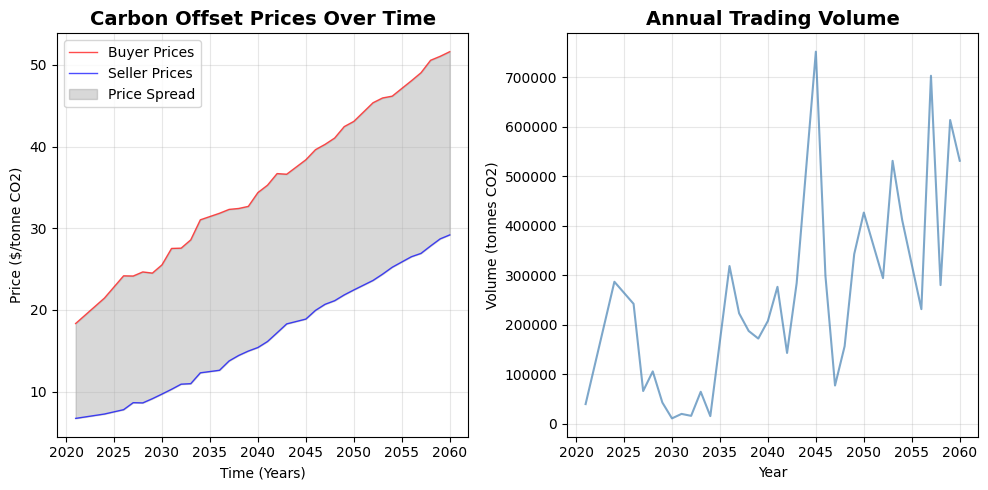


SIMULATION SUMMARY
Total auctions executed: 33
Total volume traded: 8,374,660 tonnes CO2
Average buyer price: $35.83/tonne
Average seller price: $17.05/tonne
Average price spread: $18.78/tonne
Buyer price volatility: $9.37
Seller price volatility: $6.92
Total auctioneer revenue: $200,661,744


In [18]:
analysis = analyze_carbon_offset_market(debt_df) # we can run simulation with default parameters

CARBON OFFSET MARKET SIMULATION
Running carbon offset auction simulation for 41 years...
Time steps per year: 12
Simulating year 2020...
Simulating year 2021...
Simulating year 2022...
Simulating year 2023...
Simulating year 2024...
Simulating year 2025...
Simulating year 2026...
Simulating year 2027...
Simulating year 2028...
Simulating year 2029...
Simulating year 2030...
Simulating year 2031...
Simulating year 2032...
Simulating year 2033...
Simulating year 2034...
Simulating year 2035...
Simulating year 2036...
Simulating year 2037...
Simulating year 2038...
Simulating year 2039...
Simulating year 2040...
Simulating year 2041...
Simulating year 2042...
Simulating year 2043...
Simulating year 2044...
Simulating year 2045...
Simulating year 2046...
Simulating year 2047...
Simulating year 2048...
Simulating year 2049...
Simulating year 2050...
Simulating year 2051...
Simulating year 2052...
Simulating year 2053...
Simulating year 2054...
Simulating year 2055...
Simulating year 2056...

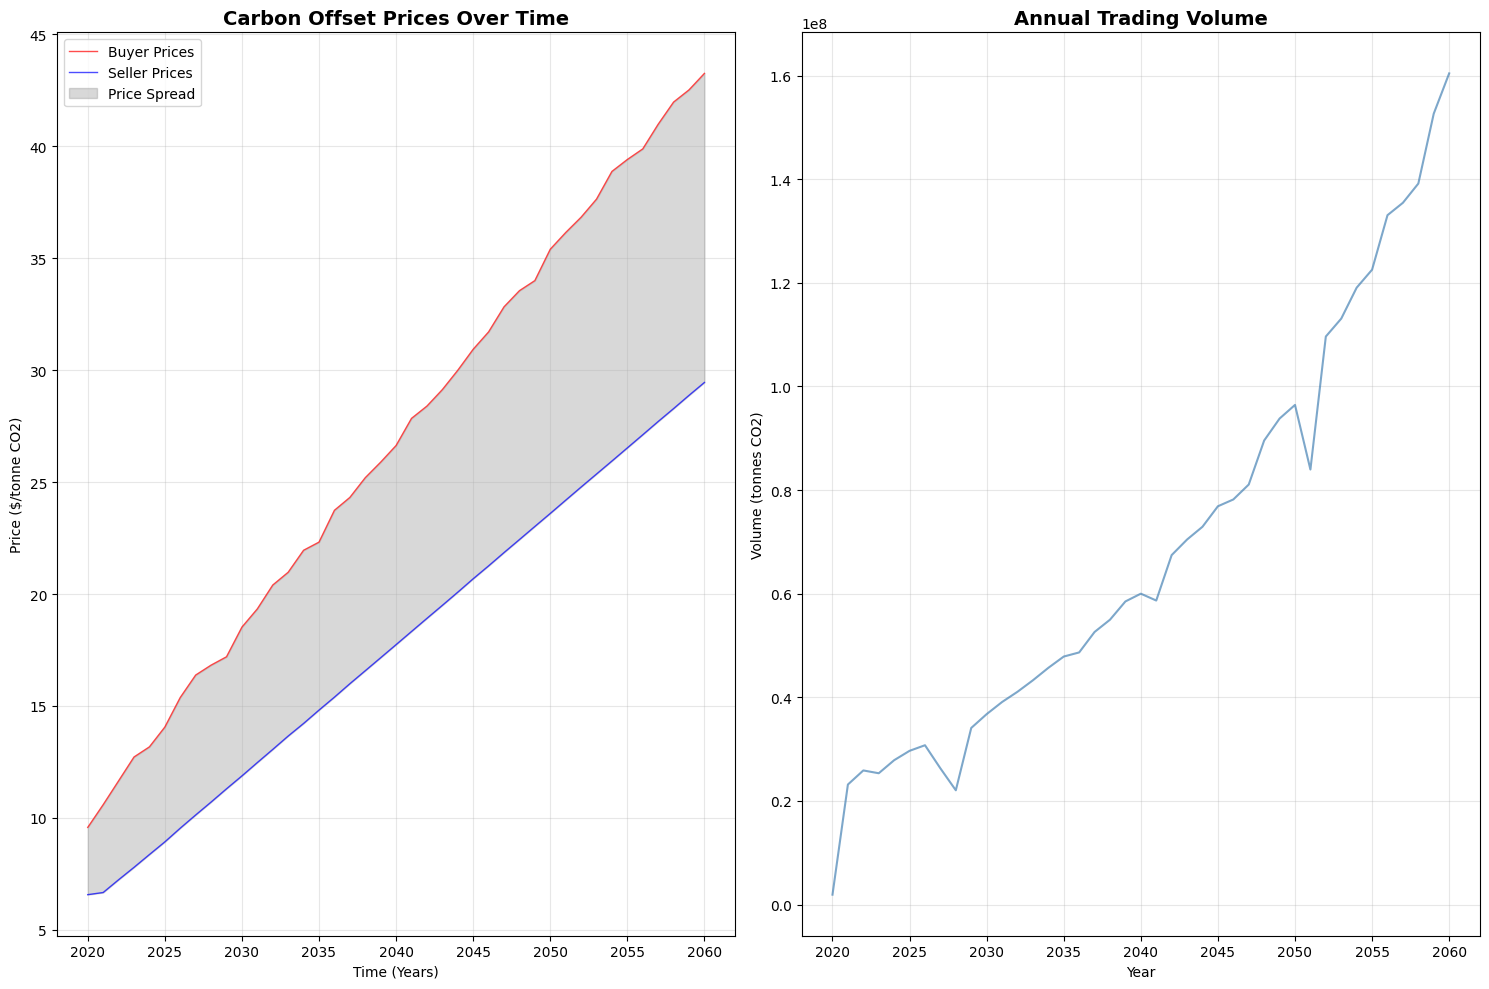


SIMULATION SUMMARY
Total auctions executed: 41
Total volume traded: 2,829,997,696 tonnes CO2
Average buyer price: $26.78/tonne
Average seller price: $17.76/tonne
Average price spread: $9.03/tonne
Buyer price volatility: $9.91
Seller price volatility: $6.91
Total auctioneer revenue: $34,551,219,632


In [12]:
# or we can run with custom parameters eg
custom_params = {
    'price_params': {
        'buyer_mean_start': 6.59,
        'buyer_mean_end': 40.0,
        'buyer_std': 1.0,
        'seller_mean_start': 6.59,
        'seller_mean_end': 30.0,
        'seller_std': 1.0,
        'price_min': 5.0,
        'price_max': 300.0
    },
    'supply_params': {
         'base_arrival_rate': 1000.0,
         'supply_growth_factor': 1.05,
         'quantity_mean': 1000.0,
         'quantity_std': 300.0,
         'quantity_min': 100.0,
         'quantity_max': 5000.0
    }
}
analysis_2 = analyze_carbon_offset_market(debt_df, custom_params)